# We can help you with that

But please plese please!!!:
- don't compute balances or transports with it!
- First aggregate (compute mean, STD, min/max) on original data, then regrid
- Again, regriding is your last operation!

## Simple scipy based methods

If you need to interpolate data for simple visualisation, just use one of the simple methods described here: https://github.com/eerie-project/EERIE_hackathon_2023/blob/main/COMMON/FESOM2_ICON_grids_easy_plot_and_interpolate.ipynb

For high resolution data it is fine to use neares neighbors. You don't "increase accuracy" of your comparison to low resolution observational data by using fancier methods, you just wait longer. However there are sometimes good reasons to do more advanced interpolation described below.

## CDO

We all know and love it. For small number of timesteps works fine.

### Basic example

For variables on nodes (vertices), which is the case for most scalars like temp and salt:

```bash
cdo -setctomiss,0 \
    -remapcon,/work/ab0995/a270088/public/grids/2t.nc \
    -setgrid,/work/ab0995/a270088/public/grids/NG5_griddes_nodes_IFS.nc \
    /work/bm1344/AWI/Cycle3/test/monthly_means/temp/temp_2020.nc \
    ./out_temp_2020.nc
```

Few important things here:
- be careful with `setctomiss`, that sets everything that is 0 to NaN. In FESOM we use 0 for missing values, wich is admitedly not the wisest choice, but, hey, that's part of the history. Will work for for most of things, but fo something like sea ice might lead to strange results.
- `remapcon` will take some file with the grid you want to interpolate to.
- `setgrid` sets the grid to our source file, as originally FESOM files do not contain information about horizontal grid
- last two files are input on FESOM grid and output file.

### Veriables on elements

In FESOM vactor variables, like U and V located at centers of elements, to interpolate them we just change the grid (`NG5_griddes_elems_IFS.nc`), otherwise the same:

```bash
cdo -setctomiss,0 \
    -remapcon,/work/ab0995/a270088/public/grids/2t.nc \
    -setgrid,/work/ab0995/a270088/public/grids/NG5_griddes_elems_IFS.nc \
    /work/bm1344/AWI/Cycle3/test/monthly_means/u/u_2020.nc \
    ./out_temp_2020.nc
```

### What if we want to generage weights?

With precomputed weights things should be much faster (did not really work for me, thoguh):

```bash
cdo -gencon,/work/ab0995/a270088/public/grids/sst.nc \
    -setgrid,/work/ab0995/a270088/public/grids//NG5_griddes_nods_IFS.nc \
    /work/bm1344/AWI/Cycle3/test/monthly_means/temp/temp_2020.nc \
    ./weights_NG5_3d_100.nc
```

and now you can use those weights in interpolation. I add couple of more options:

```bash
cdo -settunits,hours \
    -settaxis,${year}-01-15,00:00:00,1mon \
    -setctomiss,0 \
    -remap,/work/ab0995/a270088/public/grids/2t.nc,./weights_NG5_3d_100.nc \
    -setgrid,/work/ab0995/a270088/public/grids/NG5_griddes_elems_IFS.nc \
    /work/bm1344/AWI/Cycle3/test/monthly_means/${variable}/${variable}_${year}.nc \
    /work/bm1344/AWI/Cycle3/test/monthly_means/025/${variable}/${variable}_${year}_025.nc
```

- `settunits` cdo has it's very spetial ideas about how time should look like in netCDF files. Here we fix it to be "hours since"
- `settaxis` in this case we are working with monthly data, and the date was set to the end of the month, interpolated files produced by IFS have them in the middle of the month (which make sense), so we change the time axis
- `remap` since the way we remap (in this case conservative, since we used `gencon` to generate weights) is in weights, we should just provide target grid and weights (which should be consistent with target grid of course).


## SMMregrid

This method works very well when you have to do interpolation in parallel. It is based on sparce matrix multiplication, that can be done using dask. You have to install [smmregrid](https://github.com/jhardenberg/smmregrid/tree/main) package. So far we only can work with 2D data, but support for 3D is coming.

In [1]:
import intake
import smmregrid as rg

In [3]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [4]:
data = cat.FESOM['IFS_4.4-FESOM_5-cycle3']['2D_daily_native'].to_dask()

We create a dask cluster. Please adjust n_workers and memory_limit to fit your available memory:

In [5]:
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

client = Client(n_workers=20, threads_per_worker=1, memory_limit='10GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 186.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39115,Workers: 20
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 186.26 GiB
Comm: tcp://127.0.0.1:45075,Total threads: 1
Dashboard: /user/a270088/levante-spawner-preset//proxy/40539/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:39167,


We are going to regrid using precomputed weights (I generated them with AQUA, so no examples for now).
 - 1 degree `/work/ab0995/a270088/NextGems/Cycle3/weights/weights_FESOM_tco2559-ng5_original_2d_ycon_ecmwf_100_l2d.nc`
 - 0.25 degree `/work/ab0995/a270088/NextGems/Cycle3/weights/weights_FESOM_tco2559-ng5_original_2d_ycon_ecmwf_025_l2d.nc`
 
 - 1 degree ELEMENTS `/work/ab0995/a270088/NextGems/Cycle3/weights/weights_FESOM_tco2559-ng5_original_2d_ycon_ecmwf_100_l2d_elements.nc`
 - 0.25 degree ELEMENTS `/work/ab0995/a270088/NextGems/Cycle3/weights/weights_FESOM_tco2559-ng5_original_2d_ycon_ecmwf_025_l2d_elements.nc`


We are going to use 1degree weights for nodes. Let's create regrider first:

In [6]:
regridder = rg.Regridder(weights=f"/work/ab0995/a270088/NextGems/Cycle3/weights/weights_FESOM_tco2559-ng5_original_2d_ycon_ecmwf_100_l2d.nc")

In [7]:
%%time
daily_interp = regridder.regrid(data['MLD2'].sel(time=f'2021-01'))

CPU times: user 1.39 s, sys: 193 ms, total: 1.58 s
Wall time: 8.24 s


CPU times: user 1.39 s, sys: 181 ms, total: 1.58 s
Wall time: 7.32 s


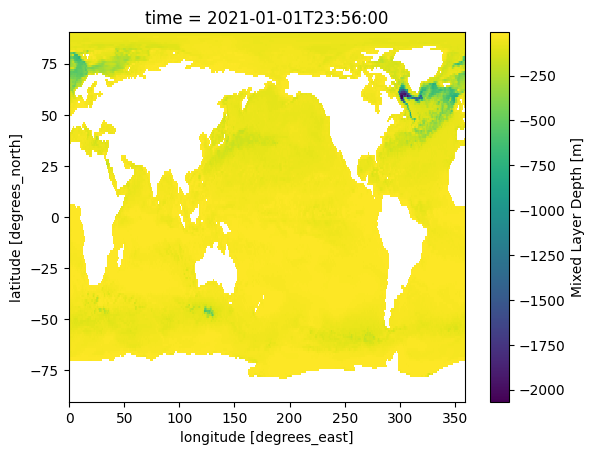

In [8]:
%%time
daily_interp[0,:].plot()

Ok, this was cheating, interpolation only happend for the first timestep, as the computations are lazy :)
Let's make it compute it for all timesteps by savind data to the disk as netCDF:

In [9]:
%%time
daily_interp.to_netcdf('/scratch/a/a270088/monthly_file.nc')

CPU times: user 1.81 s, sys: 181 ms, total: 1.99 s
Wall time: 7.26 s


Ok, that was too easy, how about the whole year of daily data:

In [10]:
%%time
daily_interp = regridder.regrid(data['MLD2'].sel(time=f'2021'))
daily_interp.to_netcdf('/scratch/a/a270088/yearly_file.nc')

CPU times: user 6.36 s, sys: 573 ms, total: 6.93 s
Wall time: 16.3 s


And the whole dataset:

In [11]:
%%time
daily_interp = regridder.regrid(data['MLD2'])
daily_interp.to_netcdf('/scratch/a/a270088/all_file.nc')

CPU times: user 33.5 s, sys: 3.19 s, total: 36.7 s
Wall time: 1min 28s


And if we want to save to zarr?

In [12]:
%%time
daily_interp = regridder.regrid(data['MLD2'])
daily_interp.to_dataset().to_zarr('/scratch/a/a270088/all_file.zarr')

CPU times: user 21.7 s, sys: 2.78 s, total: 24.5 s
Wall time: 48.9 s


## Fint

We also have [fint](https://github.com/FESOM/fint/tree/main) package, that can help you in some cases. However as first steps it is probably fine to stick with cdo of smmregrid.